# 偏差和方差 (bias and variance)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import seaborn as sns

In [3]:
def load_data():
    d = sio.loadmat('ex5data1.mat')
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

In [4]:
X, y, Xval, yval, Xtest, ytest = load_data()

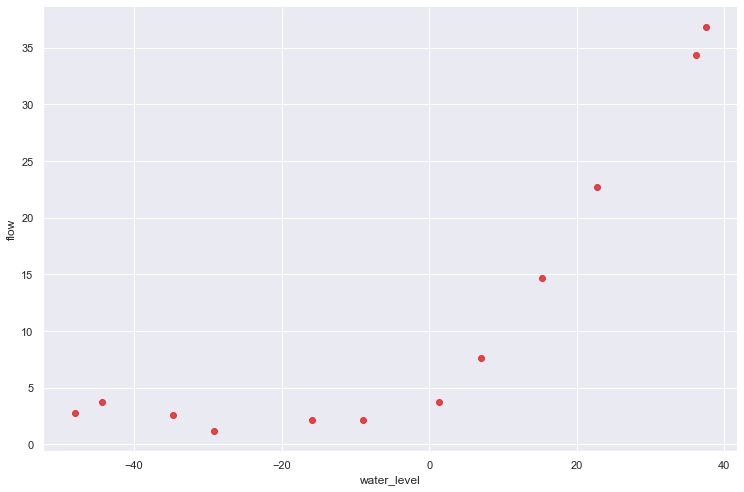

In [5]:
df = pd.DataFrame({'water_level':X, 'flow':y})
sns.set(style = 'darkgrid', palette = 'Set1')
sns.lmplot(x = 'water_level', y = 'flow', data = df, fit_reg = False, height = 7, aspect = 1.5)

In [6]:
X, Xtest, Xval = [np.insert(x.reshape(len(x),1), 0, np.ones(len(x)), axis = 1) for x in [X, Xtest, Xval]]

# 代价函数

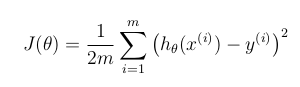

In [7]:
X

array([[  1.        , -15.93675813],
       [  1.        , -29.15297922],
       [  1.        ,  36.18954863],
       [  1.        ,  37.49218733],
       [  1.        , -48.05882945],
       [  1.        ,  -8.94145794],
       [  1.        ,  15.30779289],
       [  1.        , -34.70626581],
       [  1.        ,   1.38915437],
       [  1.        , -44.38375985],
       [  1.        ,   7.01350208],
       [  1.        ,  22.76274892]])

In [8]:
y

array([ 2.13431051,  1.17325668, 34.35910918, 36.83795516,  2.80896507,
        2.12107248, 14.71026831,  2.61418439,  3.74017167,  3.73169131,
        7.62765885, 22.7524283 ])

In [9]:
def cost(theta, X, y):
    m = len(X)
    hypothesis = X@theta
    return np.sum(np.power((hypothesis - y), 2))/(2*m)

In [10]:
theta = np.ones(X.shape[1])
cost(theta, X, y)

303.9515255535976

# 梯度

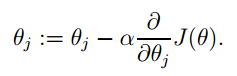

$$ \frac{\partial }{\partial \theta_j}J(\theta) = \frac{1}{m}\sum_{i = 1}^m \left(h_\theta(x^{(i)}) - y^{(i)}\right)x^{(i)}_j $$

In [11]:
def gradient(theta, X, y):
    m = len(X)
    hypothesis = X@theta
    return (hypothesis - y)@X/m

In [12]:
gradient(theta, X, y)

array([-15.30301567, 598.16741084])

# 正则化梯度

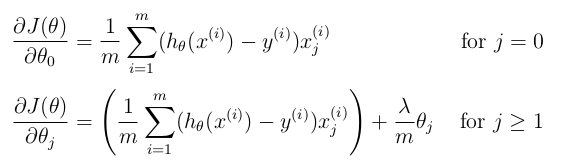

$$ J(\theta) = \frac{1}{2m}\sum_{i = 1}^m \left( h_\theta(x^{(i)}) - y^{(i)} \right)^2 + \frac{\lambda}{2m}\sum_{j = 1}^{n}\theta_j^2 $$

In [13]:
def regularized_gradient(theta, X, y, lam = 1):
    m = len(X)
    regularized_term = (lam/m)*theta
    regularized_term[0] = 0
    return gradient(theta, X, y) + regularized_term

In [14]:
regularized_gradient(theta, X, y)

array([-15.30301567, 598.25074417])

# 拟合数据

> 正则化项 $\lambda = 0$

In [15]:
def regularized_cost(theta, X, y, lam = 1):
    m = len(X)
    regularized_term = (lam/(2*m))*np.sum(np.power(theta, 2)[1:])
    return regularized_term + cost(theta, X, y)

In [16]:
def linear_regression_np(theta, X, y, lam = 1):
    # theta = np.ones(X.shape[1])
    res = opt.minimize(fun = regularized_cost, x0 = theta, args = (X, y, lam),
                       method = 'TNC', jac = regularized_gradient,
                       options = {'disp':False})
    return res

In [17]:
res = linear_regression_np(theta, X, y)
final_theta = res.x
final_theta

array([13.08771417,  0.367742  ])

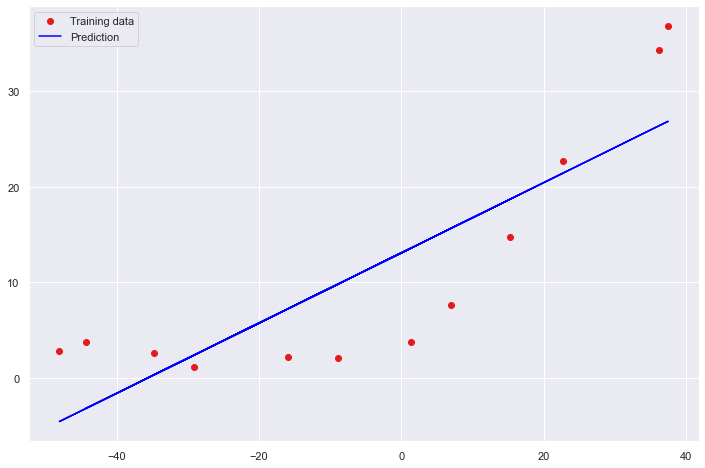

In [18]:
plt.figure(figsize = (12, 8))
plt.scatter(x = X[:,1], y = y, label = "Training data")
plt.plot(X[:,1], X@final_theta, 'b-', label = "Prediction")
plt.legend(loc = 2)
plt.show()

1. 使用训练集的子集来拟合模型


2. 在计算训练代价和交叉验证代价时，没有用正则化


3. 记住使用相同的训练集子集来计算训练代价

In [19]:
training_cost, cv_cost = [],[]
m = len(X)
theta = np.ones(X.shape[1])
for i in np.arange(1, m+1):
    res = linear_regression_np(theta, X[:i,:], y[:i], lam = 0) # 一定注意这三行的输入参数：这一行是X[:i,:], y[:i]
    training_cost.append(regularized_cost(res.x, X[:i,:], y[:i], lam = 0)) # 一定注意这三行的输入参数：这一行是X[:i,:], y[:i]
    cv_cost.append(regularized_cost(res.x, Xval, yval, lam = 0)) # 一定注意这三行的输入参数：这一行是Xval, yval，没有切片

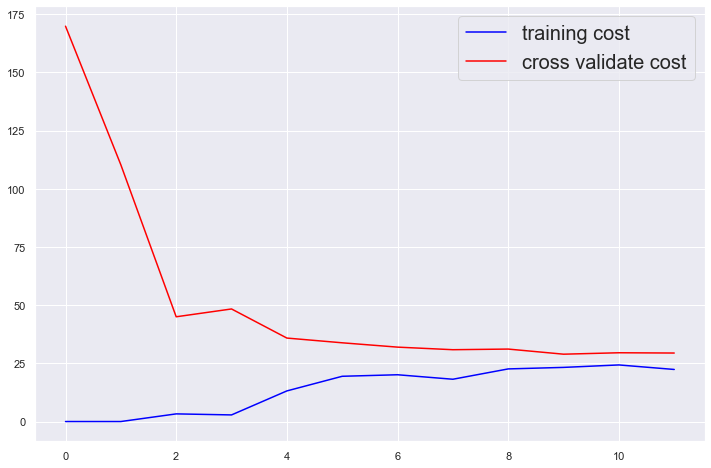

In [20]:
plt.figure(figsize = (12, 8))
plt.plot(training_cost, 'b-', label = 'training cost')
plt.plot(cv_cost, 'r-', label = 'cross validate cost')
plt.legend(loc = 1, fontsize = 20)
plt.show()

这个模型拟合不太好，**欠拟合了**

# 创建多项式特征

In [21]:
def prepare_poly_data(*args, power):
    def prepare(x):
        # expand feature
        df = poly_features(x, power = power)
        
        # normalization
        ndarr = normalize_feature(df).values
        
        # add intercept term
        return np.insert(ndarr, 0, np.ones(len(ndarr)), axis = 1)
    return [prepare(x) for x in args]

In [22]:
def poly_features(x, power, as_ndarray = False):
    data_dict = {"f{}".format(i):np.power(x,i) for i in np.arange(1, power+1)}
    df = pd.DataFrame(data_dict)
    return df.values if as_ndarray else df

In [23]:
X, y, Xval, yval, Xtest, ytest = load_data()

In [24]:
poly_features(X, power = 3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


# 准备多项式回归数据

1. 扩展特征到8阶或者到你需要的阶数


2. 使用**归一化**来合并$x^n$


3. don't forget intercept term

In [25]:
def normalize_feature(df):
    return df.apply(lambda column:(column - column.mean())/column.std())

In [26]:
X_poly, Xval_poly, Xtest_poly = prepare_poly_data(X, Xval, Xtest, power = 8)
X_poly[:3,:]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

# 画出学习曲线

> 首先，我们没有使用正则化，所以$\lambda = 0$

In [35]:
def plot_learning_curve(X, y, Xval, yval, lam = 0):
    training_cost, val_cost = [],[]
    m = len(X)
    theta = np.ones(X.shape[1])
    for i in np.arange(1, m+1):
        res = linear_regression_np(theta, X[:i,:], y[:i], lam = lam)
        
        tc = cost(res.x, X[:i,:], y[:i]) # 注意，这里使用的是cost函数，并不是regularized_cost函数
        vc = cost(res.x, Xval, yval)     # 注意，这里使用的是cost函数，并不是regularized_cost函数
        training_cost.append(tc)
        val_cost.append(vc)
    plt.figure(figsize = (9, 6))
    plt.plot(np.arange(1, m+1), training_cost, 'b-', label = 'training cost')
    plt.plot(np.arange(1, m+1), val_cost, 'r-', label = 'validation cost')
    plt.legend(loc = 1, fontsize = 15)
    plt.xlabel('Number of training data', fontsize = 15)
    plt.ylabel('Cost', fontsize = 15)
    plt.show()

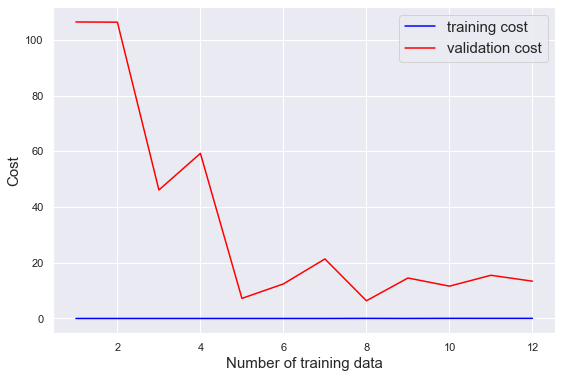

In [28]:
plot_learning_curve(X_poly, y, Xval_poly, yval, lam = 0)

你可以看到训练的代价太低了，不真实，这是**过拟合**了

# try $\lambda = 1$

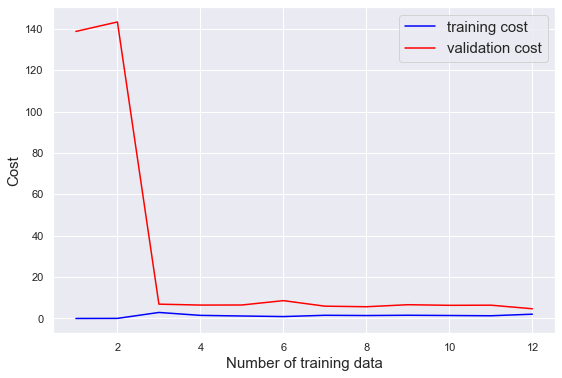

In [36]:
plot_learning_curve(X_poly, y, Xval_poly, yval, lam = 1)

训练代价增加了些，不再是0了。也就是说我们减轻了**过拟合**

# try $\lambda = 100$ 

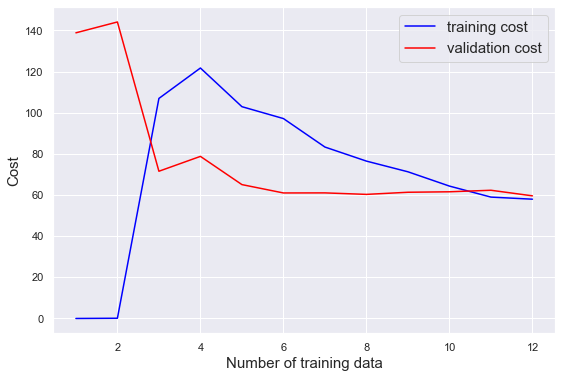

In [37]:
plot_learning_curve(X_poly, y, Xval_poly, yval, lam = 100)

太多正则化了，变成**欠拟合**状态了。（我看不太懂这种形状怎么就是欠拟合了？）

# 找到最佳的$\lambda$

In [42]:
lam_candidate = [0, 0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 
                 0.128, 0.256, 0.512, 1.024, 2.048, 4.096, 8.192]

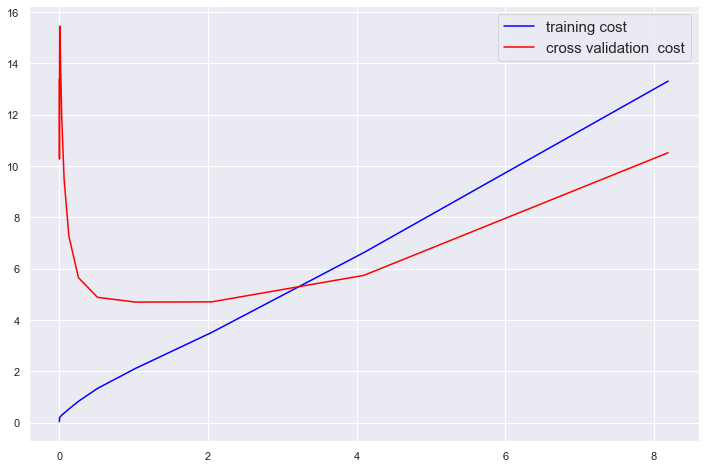

In [43]:
training_cost, cv_cost = [], []
theta = np.ones(X_poly.shape[1])
for lam in lam_candidate:
    res = linear_regression_np(theta, X_poly, y, lam)
    
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)
    
    training_cost.append(tc)
    cv_cost.append(cv)

plt.figure(figsize = (12,8))
plt.plot(lam_candidate, training_cost, 'b-', label = "training cost")
plt.plot(lam_candidate, cv_cost, 'r-', label = 'cross validation  cost')
plt.legend(loc = 1, fontsize = 15)
plt.show()

In [44]:
# best cv I got from all those candidates
lam_candidate[np.argmin(cv_cost)]

1.024

In [45]:
# use test data to compute the cost
for lam in lam_candidate:
    theta = linear_regression_np(np.ones(X_poly.shape[1]), X_poly, y, lam).x
    print("test cost(l={}) = {}".format(lam, cost(theta, Xtest_poly, ytest)))

test cost(l=0) = 10.122298845834932
test cost(l=0.001) = 10.989357236615055
test cost(l=0.002) = 11.241432524171184
test cost(l=0.004) = 11.241658121193996
test cost(l=0.008) = 11.00098723686692
test cost(l=0.016) = 10.565128440321063
test cost(l=0.032) = 9.959090437914615
test cost(l=0.064) = 9.1935201356501
test cost(l=0.128) = 8.311249166631432
test cost(l=0.256) = 7.484150670055796
test cost(l=0.512) = 7.063568899740011
test cost(l=1.024) = 7.501319264769738
test cost(l=2.048) = 9.463102789070577
test cost(l=4.096) = 14.28668657566381
test cost(l=8.192) = 23.896921053294637


调参后，$\lambda = 0.3$是最优选择，这个时候测试代价最小

（这里也不懂为什么？这是因为交叉验证集和测试集数据太少的缘故吧，所以才会导致两个集计算出来的$\lambda$有微小的差异）